In [47]:
import tensorflow 
print(tensorflow.__version__)

2.3.0


In [48]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# import dataset
project_path = '/content/drive/My Drive/AIML/PROJECT/images.npy'

In [50]:
# Load dataset
import numpy as np
data = np.load(project_path, allow_pickle=True)

In [51]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


In [52]:
# Set image dimension to 224
ALPHA = 1

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224


IMAGE_SIZE = 224

In [53]:
# Create features and labels
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [54]:
len(masks), len(X)

(409, 409)

In [55]:
# Split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size = 0.02, random_state = 2019, shuffle = False)

In [56]:
# Print the image and image shape
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (400, 224, 224, 3)
y_train shape: (400, 224, 224)
X_test shape: (9, 224, 224, 3)
y_test shape: (9, 224, 224)


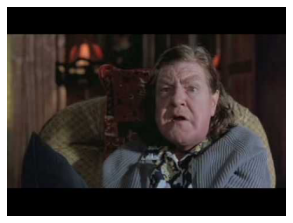

In [57]:
# plot original  training image
import matplotlib.pyplot as plt 
fig = plt.figure(figsize= (5, 5))
ax= fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(data[20][0])
plt.show()

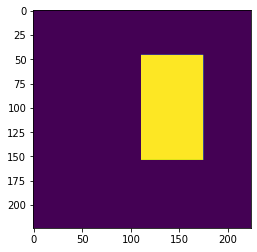

In [58]:
# plot the mask
plt.imshow(masks[20])    
plt.show()

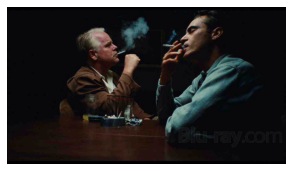

In [59]:
# plot sample Training image 
fig = plt.figure(figsize= (5, 5))
ax= fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(data[85][0])
plt.show()

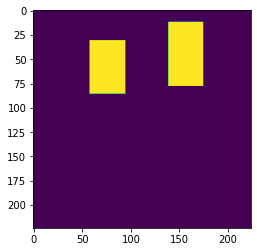

In [60]:
# Print the mask
plt.imshow(masks[85])    
plt.show()

In [61]:
# Create the model

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block5), block4])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = UpSampling2D()(x)
            
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((224, 224))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)



In [62]:
#Call the create_model function
model = create_model()

(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224)


In [63]:
#Print model summary
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

In [64]:
#Define dice coefficient function

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [65]:
#Define loss function

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [66]:
#Compile the model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [67]:
#Define callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [68]:
#Fit the model

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50, batch_size=1, verbose=1)



Epoch 1/50
400/400 [==============================] - 16s 39ms/step - loss: 1.3317 - dice_coefficient: 0.4462 - val_loss: 1.3076 - val_dice_coefficient: 0.4211
Epoch 2/50
400/400 [==============================] - 15s 38ms/step - loss: 0.7882 - dice_coefficient: 0.6133 - val_loss: 1.0686 - val_dice_coefficient: 0.4749
Epoch 3/50
400/400 [==============================] - 15s 38ms/step - loss: 0.6341 - dice_coefficient: 0.6716 - val_loss: 1.0178 - val_dice_coefficient: 0.4890
Epoch 4/50
400/400 [==============================] - 15s 38ms/step - loss: 0.5535 - dice_coefficient: 0.7060 - val_loss: 1.0619 - val_dice_coefficient: 0.4859
Epoch 5/50
400/400 [==============================] - 15s 38ms/step - loss: 0.5138 - dice_coefficient: 0.7231 - val_loss: 1.0272 - val_dice_coefficient: 0.4936
Epoch 6/50
400/400 [==============================] - 15s 38ms/step - loss: 0.4874 - dice_coefficient: 0.7344 - val_loss: 0.9666 - val_dice_coefficient: 0.5169
Epoch 7/50
400/400 [====================

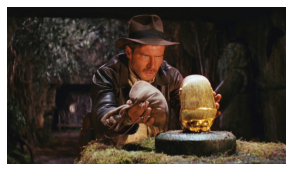

In [69]:
#Get the predicted mask for a test image

import matplotlib.pyplot as plt 
fig = plt.figure(figsize= (5, 5))
ax= fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(data[7][0])
plt.show()

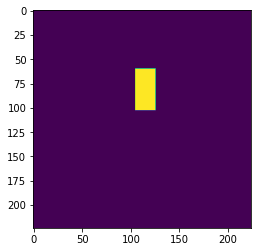

In [70]:
plt.imshow(masks[7])    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


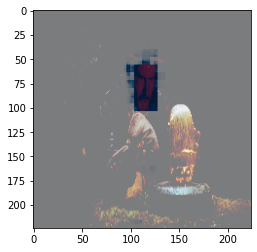

In [75]:
import matplotlib.pyplot as plt

region = model.predict(np.array([X_train[7]]))
plt.imshow(X_train[7], 'gray')

plt.imshow(region[0], "Blues", interpolation = None, alpha = 0.5)

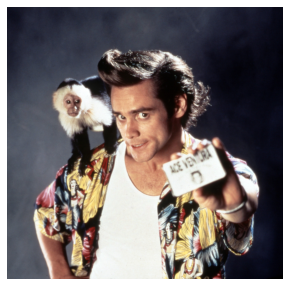

In [91]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize= (5, 5))
ax= fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(data[90][0])
plt.show()

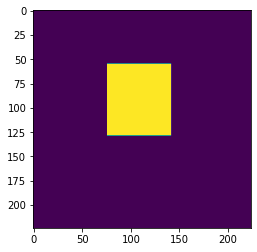

In [90]:
plt.imshow(masks[90])    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


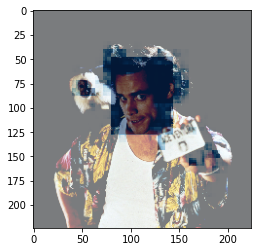

In [89]:
region = model.predict(np.array([X_train[90]]))
plt.imshow(X_train[90], 'gray')

plt.imshow(region[0], "Blues", interpolation = None, alpha = 0.5)

In [72]:
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 2ms/step - loss: 0.5826 - dice_coefficient: 0.6897


[0.5826021432876587, 0.6896621584892273]

The above built model has predicted the faces correctly. It got dice coefficient(accuracy) for test data is 68.9% and for training data dice coefficient for 50 epochs is 87.56%. 
  